In [1]:
import theano.sandbox.cuda
theano.sandbox.cuda.use('gpu0') # some other variable would need to be set with the gpuarray backend
#import theano.gpuarray
#theano.gpuarray.use('cuda1')

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5103)


In [2]:
import sys
import os
import struct
import time
import numpy as np
import h5py
from scipy.stats import pearsonr
from tqdm import tqdm
import pickle
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import src.numpy_utility as pnu
import src.fwrf as fwrf
from src.fwrf import fpX
from src.plots import display_candidate_loss
from src.data_preparation import preprocess_gabor_feature_maps
from src.load_data import load_stimuli, load_voxels

theano floatX: float32
numpy floatX: <type 'numpy.float32'>


In [3]:
timestamp = time.strftime('%b-%d-%Y_%H%M', time.localtime())

root_dir   = os.getcwd() + '/'
output_dir = root_dir+"output/"

print "Time Stamp: %s" % timestamp

Time Stamp: Aug-02-2017_1229


In [4]:
dataset_dir = "/home/styvesg/Documents/PostDoc/Datasets/vim-1/"

# 1a) Load the image dataset (the images that were presented to the subject for which we have voxel data)

## Load vim-1 dataset

In [5]:
stimuli_lowrez, stimuli_hirez, trn_size = load_stimuli(dataset_dir, npx=227)

data_size = len(stimuli_hirez)
val_size = data_size - trn_size

trn_stim_data = stimuli_hirez[:trn_size]
val_stim_data = stimuli_hirez[trn_size:]

trn: 1750, val: 120
Data shape = (1870, 1, 227, 227)


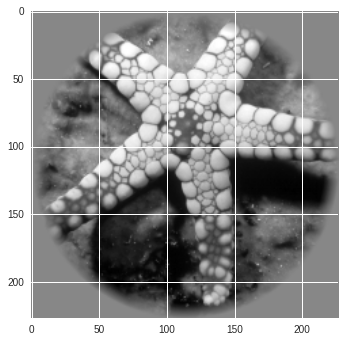

In [6]:
plt.imshow(trn_stim_data[5,0,:,:], cmap='gray')

# 1b) Load the corresponding voxel data

In [7]:
subject = 'S1'
roi_names = ['other', 'V1', 'V2', 'V3', 'V3a', 'V3b', 'V4', 'LO']

In [8]:
voxel_data, voxel_roi, voxel_idx = load_voxels(dataset_dir, subject, voxel_subset=range(3000, 4000))

nv = voxel_data.shape[1]
print "nv = %d" % nv

trn_voxel_data = voxel_data[:trn_size]
val_voxel_data = voxel_data[trn_size:]

22701 voxels contain valid values for all images
nv = 1000


# 0) Create the feature space and generate the feature maps for the dataset

In [9]:
model_name = 'gabor'
from gaborizer.src.gabor_feature_dictionaries import gabor_feature_maps

In [10]:
gabor_params = {
    'n_orientations': 4,
    'deg_per_stimulus': 20.,
    'lowest_sp_freq': 0.25, ##cyc/deg
    'highest_sp_freq': 6.0,
    'num_sp_freq': 12,
    'pix_per_cycle': 3.13, #2.13333333
    'complex_cell': True,
    'n_colors': 1, ##let's do grayscale first
    'diams_per_filter': 4.,
    'cycles_per_radius': 1.
}

print 'D = total number of features = %d' %(gabor_params['n_orientations'] * gabor_params['num_sp_freq'])

D = total number of features = 48


In [11]:
gfm = gabor_feature_maps(gabor_params['n_orientations'],
                         gabor_params['deg_per_stimulus'],
                         (gabor_params['lowest_sp_freq'], gabor_params['highest_sp_freq'], gabor_params['num_sp_freq']),
                         pix_per_cycle=gabor_params['pix_per_cycle'], complex_cell=gabor_params['complex_cell'],
                         diams_per_filter = gabor_params['diams_per_filter'],
                         cycles_per_radius = gabor_params['cycles_per_radius'])

In [12]:
print gfm.filter_stack.shape
gfm.gbr_table.head(17)

(48, 1, 25, 25)


,cycles per deg.,cycles_per_filter,filter size (deg.),pix per stimulus,pix_per_filter,radius of Gauss. envelope (deg),orientation
0,0.250000,8,32.000000,15.650000,25,4.000000,0.000000
1,0.333744,8,23.970452,20.892388,25,2.996307,0.000000
2,0.445541,8,17.955706,27.890856,25,2.244463,0.000000
3,0.594787,8,13.450200,37.233648,25,1.681275,0.000000
4,0.794027,8,10.075230,49.706060,25,1.259404,0.000000
5,1.060007,8,7.547120,66.356442,25,0.943390,0.000000
6,1.415085,8,5.653371,88.584316,25,0.706671,0.000000
7,1.889106,8,4.234808,118.258015,25,0.529351,0.000000
8,2.521912,8,3.172196,157.871718,25,0.396524,0.000000
9,3.366695,8,2.376218,210.755096,25,0.297027,0.000000


float64
(48, 1, 25, 25)


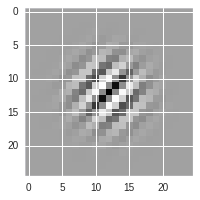

In [13]:
print np.real(gfm.filter_stack).dtype

#complex fs = np.stack([np.real(gfm.filter_stack), np.imag(gfm.filter_stack), np.zeros(shape=gfm.filter_stack.shape)]).transpose([1,2,3,4,0])
fs = np.real(gfm.filter_stack)
print fs.shape 
fig=plt.figure(figsize=(3,3))
plt.imshow(fs[15, 0, :, :], interpolation='None')

In [14]:
log_act_func = lambda x: np.log(1+np.sqrt(x))
fmaps, _fmaps, fmaps_sizes = preprocess_gabor_feature_maps(gfm.create_feature_maps(stimuli_hirez), log_act_func, dtype=fpX)

fmaps_res_count = len(fmaps_sizes)
fmaps_count = sum([fm[1] for fm in fmaps_sizes])
nf = fmaps_count

allocating memory for feature maps
constructing feature maps
feature 0 took 0.240413 s.
feature 1 took 0.255824 s.
feature 2 took 0.290035 s.
feature 3 took 0.385609 s.
feature 4 took 0.601406 s.
feature 5 took 1.010056 s.
feature 6 took 1.843007 s.
feature 7 took 3.343962 s.
feature 8 took 6.219592 s.
feature 9 took 11.492848 s.
feature 10 took 20.955456 s.
feature 11 took 38.344157 s.
feature 12 took 0.220529 s.
feature 13 took 0.242122 s.
feature 14 took 0.285008 s.
feature 15 took 0.384067 s.
feature 16 took 0.607009 s.
feature 17 took 1.026114 s.
feature 18 took 1.875973 s.
feature 19 took 3.427567 s.
feature 20 took 6.229635 s.
feature 21 took 11.482232 s.
feature 22 took 20.945445 s.
feature 23 took 38.360315 s.
feature 24 took 0.236247 s.
feature 25 took 0.247524 s.
feature 26 took 0.291765 s.
feature 27 took 0.385040 s.
feature 28 took 0.605509 s.
feature 29 took 1.014395 s.
feature 30 took 1.849204 s.
feature 31 took 3.351062 s.
feature 32 took 6.238028 s.
feature 33 took 11.

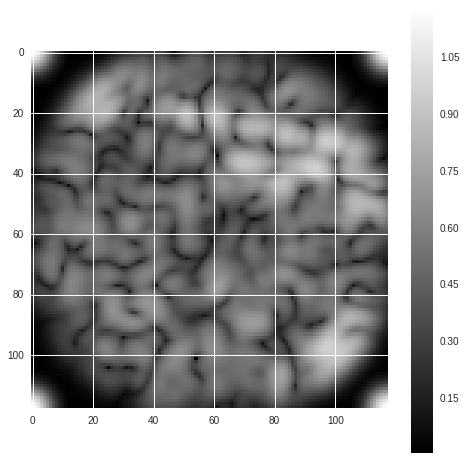

In [15]:
fig=plt.figure(figsize=(8,8))
plt.imshow(fmaps[7][-1,1,:,:], cmap='gray', interpolation='None')
plt.colorbar()

# 2) MODELS
## Define the search parameters

In [21]:
lx = ly = 20.
nx = ny = 26
smin, smax = 0.5, 8.
ns = 12

# sharedModel specification is a list of 3 ranges and 3 callable functor. The reason for this is for a future implementation of dynamic mesh refinement.
sharedModel_specs = [[(0., lx), (0., ly), (smin, smax)], [fwrf.linspace(nx), fwrf.linspace(ny), fwrf.logspace(ns)]]
# initial values of the fwrf model parameters
voxelParams = [np.full(shape=(nv, nf), fill_value=0.0, dtype=fpX), np.full(shape=(nv), fill_value=0.0, dtype=fpX)]

print "G = %d\n" % (nx*ny*ns)
#print range:
print "range x"
print sharedModel_specs[1][0](*sharedModel_specs[0][0])
print "range y"
print sharedModel_specs[1][1](*sharedModel_specs[0][1])
print "range s"
print sharedModel_specs[1][2](*sharedModel_specs[0][2])

G = 8112

range x
[-9.61538506 -8.84615421 -8.07692337 -7.30769253 -6.53846169 -5.76923084
 -5.         -4.23076916 -3.46153855 -2.69230771 -1.92307687 -1.15384614
 -0.38461539  0.38461539  1.15384614  1.92307687  2.69230771  3.46153855
  4.23076916  5.          5.76923084  6.53846169  7.30769253  8.07692337
  8.84615421  9.61538506]
range y
[-9.61538506 -8.84615421 -8.07692337 -7.30769253 -6.53846169 -5.76923084
 -5.         -4.23076916 -3.46153855 -2.69230771 -1.92307687 -1.15384614
 -0.38461539  0.38461539  1.15384614  1.92307687  2.69230771  3.46153855
  4.23076916  5.          5.76923084  6.53846169  7.30769253  8.07692337
  8.84615421  9.61538506]
range s
[ 0.5         0.64333242  0.82775331  1.06504107  1.37035096  1.76318252
  2.26862502  2.91896009  3.75572371  4.83235788  6.21762514  8.        ]


## Example of a f.p.f. as it appears at the different feature map resolutions

[ 0.5         0.64333242  0.82775331  1.06504107  1.37035096  1.76318252
  2.26862502  2.91896009  3.75572371  4.83235788  6.21762514  8.        ]


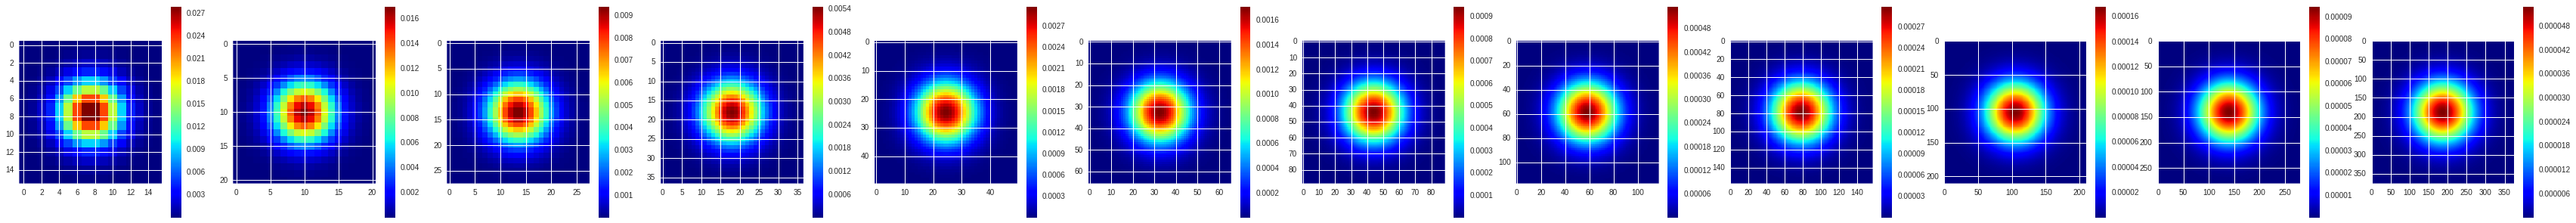

In [22]:
sigmas = sharedModel_specs[1][2](*sharedModel_specs[0][2])
print sigmas

ith_rf_size = 7
n = len(fmaps_sizes)
plt.figure(figsize=(5*n,5))
for i,r in enumerate(fmaps_sizes):
    _,_,z = pnu.make_gaussian_mass(0., 0., sigmas[ith_rf_size], r[2], size=20.)
    plt.subplot(1,n,i+1)
    plt.imshow(z, interpolation='None', cmap='jet')
    plt.colorbar()

---
# This is where the fwRF model is trained
## 2a) Precompute and save the modelspace tensor

In [23]:
mst_data, mst_avg, mst_std = fwrf.model_space_tensor(fmaps, sharedModel_specs, nonlinearity=None, \
                zscore=True, trn_size=trn_size, epsilon=1e-6, batches=(500, nx*ny), view_angle=lx, verbose=True, dry_run=False)
print mst_data.shape

CREATING SYMBOLS

> feature map candidates 0 with shape (1, 676, 16, 16)
> feature map candidates 1 with shape (1, 676, 21, 21)
> feature map candidates 2 with shape (1, 676, 28, 28)
> feature map candidates 3 with shape (1, 676, 37, 37)
> feature map candidates 4 with shape (1, 676, 50, 50)
> feature map candidates 5 with shape (1, 676, 66, 66)
> feature map candidates 6 with shape (1, 676, 89, 89)
> feature map candidates 7 with shape (1, 676, 118, 118)
> feature map candidates 8 with shape (1, 676, 158, 158)
> feature map candidates 9 with shape (1, 676, 211, 211)
> feature map candidates 10 with shape (1, 676, 281, 281)
> feature map candidates 11 with shape (1, 676, 376, 376)
  total number of feature maps = 48, in 12 layers
  feature map candidate using approx 828.7 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 2.713Gb of RAM!
>> Will be divided in chunks of 0.226Gb of VRAM!

COMPILING...
1.08 seconds to compile theano functions

Precomputi

100%|██████████| 12/12 [02:28<00:00, 12.32s/it]

8112 mst candidate responses took 148.050s @ 54.792 models/s
Z-scoring modelspace tensor...
Using self z-scoring values.



12it [00:10,  1.17it/s]

(1870, 48, 1, 8112)


In [24]:
print np.amin(mst_data), np.amax(mst_data)
# split the model space tensor into trn and val set.
trn_mst_data = mst_data[:trn_size]
val_mst_data = mst_data[trn_size:]

-22.4696 13.9495


## 2b) Learn the model parameters

In [25]:
val_scores, best_scores, best_epochs, best_candidates, best_w_params = fwrf.learn_params(
        trn_mst_data, trn_voxel_data, voxelParams, batches=(200, 1000, 2*nx*ny), \
        val_test_size=350, lr=1e-3, l2=0.0, num_epochs=40, output_val_scores=-1, output_val_every=1, verbose=True, dry_run=False)

Grad. Desc. planned in 7 batch with batch size 200 and residual 0
1 voxel batches of size 1000 with residual 0
6 candidate batches of size 1352 with residual 0
for 8112000 voxelmodel fits.
CREATING SYMBOLS

Layer	: <lasagne.layers.input.InputLayer object at 0x7f06c7439810>
Name	: None
Type	: <class 'lasagne.layers.input.InputLayer'>
Shape	: (None, 48, 1352)


Layer	: <src.fwrf.svFWRFLayer object at 0x7f06c7cfc910>
Name	: None
Type	: <class 'src.fwrf.svFWRFLayer'>
Shape	: (None, 1000, 1352)
Params
        |-- W         : (48, 1000, 1352)
        |-- b         : (1, 1000, 1352)


COMPILING...
0.50 seconds to compile theano functions

Voxel-Candidates model optimization...

0it [00:00, ?it/s]



  Voxel 0:1000 of 1000, Candidate 0:1352 of 8112
    validation <loss>: 0.005686
    validation <loss>: 0.005684
    validation <loss>: 0.005683
    validation <loss>: 0.005682
    validation <loss>: 0.005682
    validation <loss>: 0.005682
    validation <loss>: 0.005682
    validation <loss>: 0.005682
    validation <loss>: 0.005682
    validation <loss>: 0.005682
    validation <loss>: 0.005682
    validation <loss>: 0.005682
    validation <loss>: 0.005682
    validation <loss>: 0.005683
    validation <loss>: 0.005683
    validation <loss>: 0.005683
    validation <loss>: 0.005683
    validation <loss>: 0.005683
    validation <loss>: 0.005684
    validation <loss>: 0.005684
    validation <loss>: 0.005684
    validation <loss>: 0.005685
    validation <loss>: 0.005685
    validation <loss>: 0.005685
    validation <loss>: 0.005686
    validation <loss>: 0.005686
    validation <loss>: 0.005686
    validation <loss>: 0.005687
    validation <loss>: 0.005687
    validation <loss>

1it [14:37, 877.76s/it]


---------------------------------------------------------------------
40 Epoch for 8112000 voxelmodels took 877.767s @ 9241.634 voxelmodels/s


## 2c) Convert modelspace tensor best candidates into real space and separate voxel models

In [26]:
best_rf_params, best_avg, best_std = fwrf.real_space_model(best_candidates, sharedModel_specs, mst_avg=mst_avg, mst_std=mst_std)

## 2d) Validate the best models and display the distribution of prediction accuracy

In [27]:
val_pred, val_cc = fwrf.get_prediction(val_mst_data, val_voxel_data, best_candidates, best_w_params, batches=(500, 2*ny*nx))

0 voxel batches of size 1352 with residual 1000
CREATING SYMBOLS

COMPILING...


1it [00:00, 10.92it/s]

0.60 seconds to compile theano functions


max cc = 0.752374
sum(cc>0.2) = 142


(-0.4, 0.9)

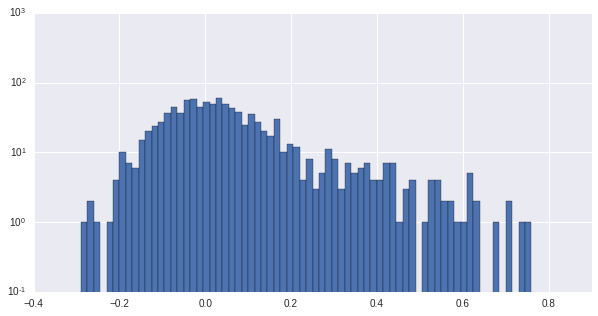

In [28]:
print "max cc = %f" % np.max(val_cc)
print "sum(cc>0.2) = %d" % np.sum(map(lambda x: x > 0.2, val_cc))
plt.figure(figsize=(10,5))
_=plt.hist(val_cc[:], bins=100, range=(-.5, 1.))
plt.yscale('log')
plt.ylim([10**-1, 10**3])
plt.xlim([-.4, 0.9])

---
# Quick diagnostic of learning

[ 2.69230771  9.61538506  0.5       ]
score range = (0.003765, 0.005597)


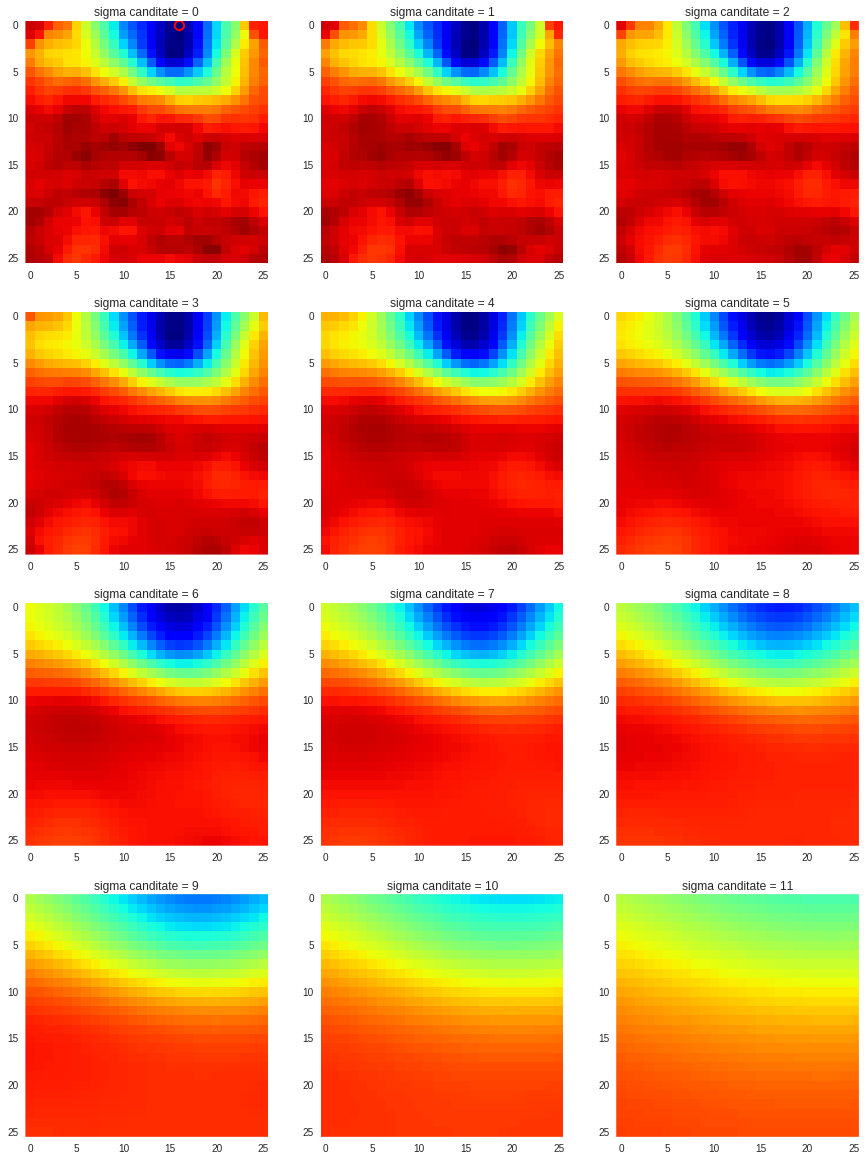

In [29]:
vidx = np.argmax(val_cc)
print best_rf_params[vidx,:]
fig1 = display_candidate_loss(val_scores[-1,vidx,:], nx, ny, ns)

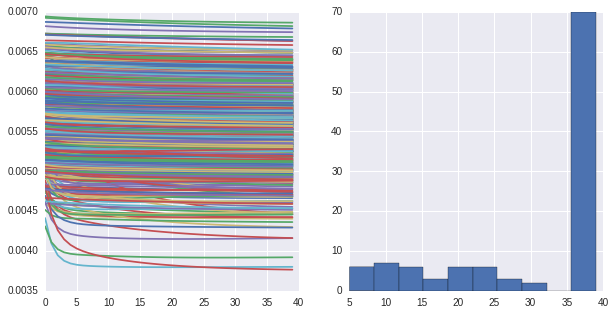

In [30]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
for v in range(val_scores.shape[1]):
    plt.plot(val_scores[:,v,best_candidates[v]])
plt.subplot(1,2,2)    
_=plt.hist(best_epochs[val_cc>0.27])

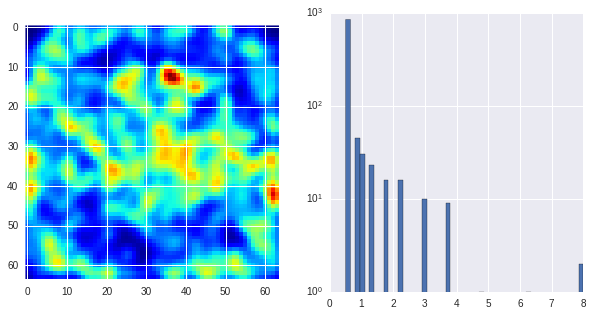

In [31]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
_,_,g_stack = pnu.make_gaussian_stack(best_rf_params[:,0], best_rf_params[:,1], best_rf_params[:,2], 64, size=20., dtype=fpX)
plt.imshow(np.sum(g_stack, axis=0), interpolation='None', cmap='jet')
plt.subplot(1,2,2)
_=plt.hist(best_rf_params[:,2], bins=50)
plt.yscale('log')

[[ 1.         0.7523744]
 [ 0.7523744  1.       ]]


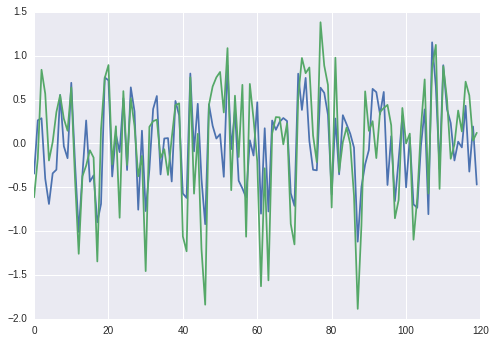

In [32]:
plt.plot(val_pred[:,vidx])
plt.plot(val_voxel_data[:,vidx])

print np.corrcoef(val_pred[:,vidx], val_voxel_data[:,vidx])

In [ ]:
***

In [40]:
ex_file_name = output_dir + "fwrf_%s_%s_%s_data.pkl" % (model_name, subject, timestamp)
ex_file = open(ex_file_name, 'wb')
ex_values = {'project': 'fwrf',
             'dataset': 'vim-1',
             'subject': subject,
             'model_name': model_name,
             'grid': [sharedModel_specs[1][0](*sharedModel_specs[0][0]), 
                      sharedModel_specs[1][1](*sharedModel_specs[0][1]),
                      sharedModel_specs[1][2](*sharedModel_specs[0][2])],
             'gabor_params': gabor_params,
             'voxel_idx': voxel_idx,
             'voxel_roi': voxel_roi,             
             'fmaps_res_count': fmaps_res_count,
             'fmaps_count': fmaps_count,
             'fmaps_sizes': fmaps_sizes, 
             'scores': best_scores,
             'rf_params': best_rf_params,
             'w_params': best_w_params,
             'normavg': best_avg,
             'normstd': best_std, 
             'val_pred': val_pred,
             'val_cc': val_cc}
pickle.dump(ex_values, ex_file)
ex_file.close()
print ex_file_name

/home/styvesg/Documents/PostDoc/Programs/JupyterNotebooks/fwrf-master/output/fwrf_S1_Mar-24-2017_1455_data.pkl


In [41]:
#data_file = open(output_dir + "fwrf_model_S1_Feb-17-2017_1812.pkl", 'rb')
#data_value = pickle.load(data_file)
#data_file.close()

# Split accuracy by layer and roi

In [42]:
#find the start and end point of the feature map partitions
fmaps_count = len(fmaps_sizes)
partitions = [0,]
for r in fmaps_sizes:
    partitions += [partitions[-1]+r[1],]
print partitions

[0, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48]


In [43]:
partition_val_pred = np.ndarray(shape=(fmaps_count,)+val_pred.shape, dtype=fpX)
partition_val_cc   = np.ndarray(shape=(fmaps_count,)+val_cc.shape, dtype=fpX)

for l in range(fmaps_count):
    partition_params = [np.zeros(p.shape, dtype=fpX) for p in best_params]  
    partition_params[0][:, partitions[l]:partitions[l+1]] = best_w_params[0][:, partitions[l]:partitions[l+1]]
    partition_params[1][:] = best_w_params[1][:]

    partition_val_pred[l,...], partition_val_cc[l,...] = fwrf.get_prediction(val_mst_data, val_voxel_data, best_candidates, partition_params, batches=(500, 2*ny*nx))

16 voxel batches of size 1352 with residual 1069


17it [00:01,  8.69it/s]

16 voxel batches of size 1352 with residual 1069



17it [00:01,  9.74it/s]

16 voxel batches of size 1352 with residual 1069



17it [00:01,  9.81it/s]

16 voxel batches of size 1352 with residual 1069



17it [00:01,  9.80it/s]

16 voxel batches of size 1352 with residual 1069



17it [00:01,  9.59it/s]

16 voxel batches of size 1352 with residual 1069



17it [00:01,  9.71it/s]

16 voxel batches of size 1352 with residual 1069



17it [00:01,  9.68it/s]

16 voxel batches of size 1352 with residual 1069



17it [00:01,  9.86it/s]

16 voxel batches of size 1352 with residual 1069



17it [00:01,  9.76it/s]

16 voxel batches of size 1352 with residual 1069



17it [00:01,  9.74it/s]

16 voxel batches of size 1352 with residual 1069



17it [00:01,  9.87it/s]

16 voxel batches of size 1352 with residual 1069



17it [00:01,  9.75it/s]


In [44]:
# calculate covariances
partition_r = np.ndarray(shape=(fmaps_count, nv))
for v in range(nv):
    full_c = np.cov(val_pred[:,v], val_voxel_data[:,v])
    for l in range(fmaps_count):
        part_c = np.cov(partition_val_pred[l,:,v], val_voxel_data[:,v])
        partition_r[l,v] = part_c[0,1]/np.sqrt(full_c[0,0]*full_c[1,1])

In [45]:
part_file = open(output_dir + "fwrf_%s_%s_%s_part.pkl" % (model_name, subject, timestamp), 'wb')
part_values = {'dataset': 'vim-1',
             'subject': subject,
             'model_name': model_name,
             'val_pred': partition_val_pred,
             'val_cc': partition_val_cc,
             'val_ri': partition_r}
pickle.dump(part_values, part_file)
part_file.close()

In [46]:
nROI = int(np.max(voxelROI))+1
nL   = fmaps_count

partition_R_avg = np.ndarray(shape=(fmaps_count, nROI), dtype=fpX)
partition_R_std = np.ndarray(shape=(fmaps_count, nROI), dtype=fpX)
for roi in range(nROI):
    roi_mask = np.logical_and(voxelROI.flatten()==roi, val_cc>0.2)    
    for l in range(fmaps_count):
        partition_R_avg[l,roi] = np.mean(partition_r[l, roi_mask] /  val_cc[roi_mask])
        partition_R_std[l,roi] = np.std(partition_r[l, roi_mask])
#plt.imshow(partition_R_avg, interpolation='None')

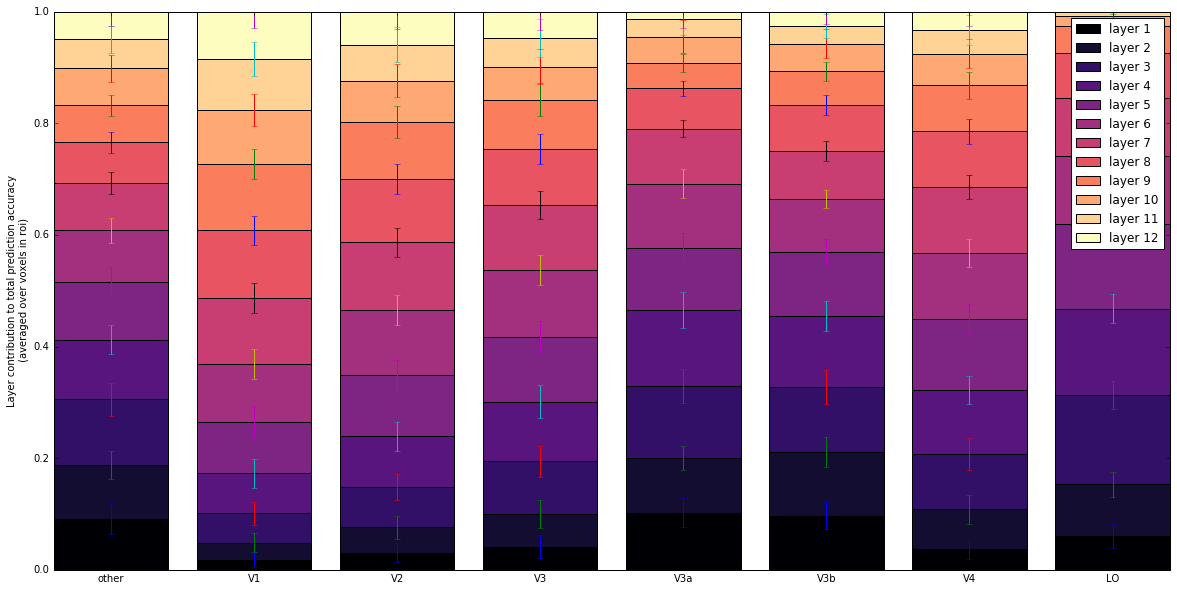

In [47]:
from matplotlib.pyplot import cm 
color=iter(cm.magma(np.linspace(0,1,nL)))

plt.figure(figsize=(20,10))
c=next(color)
plist = []
_ = plt.bar(np.arange(len(roi_names)), partition_R_avg[0,:], yerr=partition_R_std[0,:], color=c, align='center')
plist += [_,]
for l in range(1,nL):
    c=next(color)
    _= plt.bar(np.arange(len(roi_names)), partition_R_avg[l,:], bottom=np.sum(partition_R_avg[:l,:],axis=0), yerr=partition_R_std[l,:], color=c,\
        align='center', tick_label=roi_names)
    plist += [_,]
plt.legend(plist, ['layer %d' % l for l in range(1,len(plist)+1)])
plt.ylim([0,1])
plt.ylabel('Layer contribution to total prediction accuracy\n (averaged over voxels in roi)')